In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, mean_absolute_error,
    mean_squared_error, mean_absolute_percentage_error,
    explained_variance_score, r2_score
)


In [2]:
def load_images(folder_path, label, image_size=64):
    images = []
    labels = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".jpg"):
            image_path = os.path.join(folder_path, file_name)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                image_resized = cv2.resize(image, (image_size, image_size))
                images.append(image_resized.flatten())  # Flatten the image
                labels.append(label)
    return np.array(images), np.array(labels)

# Load healthy and unhealthy images
healthy_images, healthy_labels = load_images('D:/AI Algorithm/cucumber/healthy/', 0)
unhealthy_images, unhealthy_labels = load_images('D:/AI Algorithm/cucumber/unhealthy/', 1)

# Combine images and labels
X = np.concatenate((healthy_images, unhealthy_images), axis=0)
y = np.concatenate((healthy_labels, unhealthy_labels), axis=0)


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:
# Initialize and train the SVM model
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train, y_train)


SVC(kernel='linear', probability=True, random_state=42)

In [6]:
# Predict on the test set
y_pred = svm_model.predict(X_test)
y_prob = svm_model.predict_proba(X_test)[:, 1]  # Probability for ROC-AUC

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
conf_matrix = confusion_matrix(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)
explained_var = explained_variance_score(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Compute SMAPE (Systematic Mean Absolute Percentage Error)
epsilon = 1e-10  # Small constant to prevent division by zero
smape = 100 * np.mean(2 * np.abs(y_pred - y_test) / (np.abs(y_pred) + np.abs(y_test) + epsilon))

# Mean Bias Deviation (MBD)
mbd = np.mean(y_pred - y_test)

# Display metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"AUC: {auc:.2f}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}")
print(f"Systematic Mean Absolute Percentage Error (SMAPE): {smape:.2f}")
print(f"Explained Variance Score: {explained_var:.2f}")
print(f"R^2 Score: {r2:.2f}")
print(f"Mean Bias Deviation (MBD): {mbd:.2f}")


Accuracy: 0.73
Precision: 0.84
Recall: 0.76
F1-Score: 0.80
AUC: 0.82
Confusion Matrix:
[[ 47  23]
 [ 39 122]]
Mean Absolute Error (MAE): 0.27
Mean Squared Error (MSE): 0.27
Root Mean Squared Error (RMSE): 0.52
Mean Absolute Percentage Error (MAPE): 448410352508750.81
Systematic Mean Absolute Percentage Error (SMAPE): 53.68
Explained Variance Score: -0.25
R^2 Score: -0.27
Mean Bias Deviation (MBD): -0.07


In [7]:
import joblib

# Save the model
joblib.dump(svm_model, 'svm_leaf_health_model.pkl')
print("SVM model saved as 'svm_leaf_health_model.pkl'")


SVM model saved as 'svm_leaf_health_model.pkl'


In [9]:
def predict_leaf_health_svm(image_path):
    # Load the saved model
    loaded_svm_model = joblib.load('svm_leaf_health_model.pkl')
    
    # Load and preprocess the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError("Image not found or invalid format.")
    image_resized = cv2.resize(image, (64, 64))
    image_flattened = image_resized.flatten().reshape(1, -1)
    
    # Predict using the model
    prediction = loaded_svm_model.predict(image_flattened)
    return "Healthy" if prediction[0] == 0 else "Unhealthy"

# Example usage
new_image_path = 'D:/AI Algorithm/cucumber/test_image.jpg'  # Replace with a new image path
result = predict_leaf_health_svm(new_image_path)
print(f"The leaf is: {result}")


The leaf is: Healthy


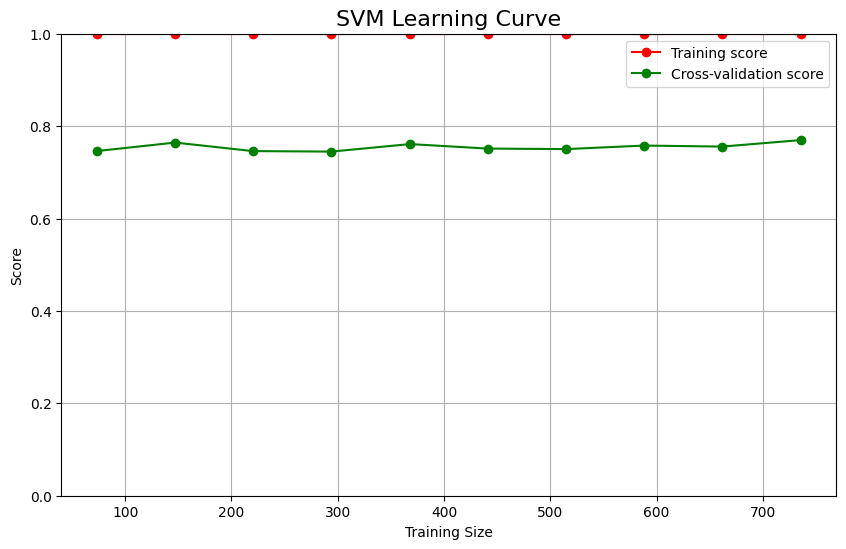

In [6]:
from sklearn.model_selection import learning_curve

# Function to plot the learning curve
def plot_learning_curve(estimator, X, y, title="Learning Curve", cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.title(title, fontsize=16)
    plt.xlabel("Training Size")
    plt.ylabel("Score")
    plt.ylim(0, 1)  # Fix y-axis between 0 and 1
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Plot the learning curve
plot_learning_curve(svm_model, X_train, y_train, title="SVM Learning Curve")


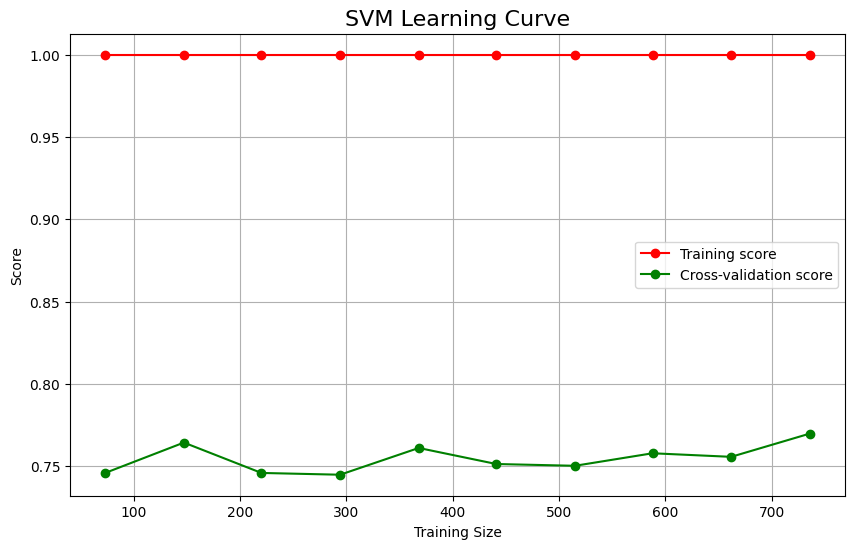

In [7]:
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, auc

# Function to plot the learning curve
def plot_learning_curve(estimator, X, y, title="Learning Curve", cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.title(title, fontsize=16)
    plt.xlabel("Training Size")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Plot the learning curve
plot_learning_curve(svm_model, X_train, y_train, title="SVM Learning Curve")

